# (4주차) 3월28일 -- draft

- toc:true
- branch: master
- badges: true
- comments: true
- author: 최규빈

### 강의영상 

### imports

In [55]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
import tensorflow.experimental.numpy as tnp 

In [3]:
tnp.experimental_enable_numpy_behavior() 

### 미분 

#### tf.GradientTape() 사용방법

`-` 예제9: 카페예제로 돌아오자. 

In [6]:
x= tnp.array([20.1, 22.2, 22.7, 23.3, 24.4, 25.1, 26.2, 27.3, 28.4, 30.4])

In [7]:
tf.random.set_seed(43052)
epsilon=tf.random.normal([10])
y=10.2 + 2.2*x + epsilon

In [8]:
y

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([55.4183651 , 58.19427589, 61.23082496, 62.31255873, 63.1070028 ,
       63.69569103, 67.24704918, 71.43650092, 73.10130336, 77.84988286])>

In [9]:
beta0 = tf.Variable(9.0) 
beta1 = tf.Variable(2.0)  

In [10]:
with tf.GradientTape(persistent=True) as tape: 
    loss = sum((y-beta0-beta1*x)**2)

In [11]:
tape.gradient(loss,beta0), tape.gradient(loss,beta1)

(<tf.Tensor: shape=(), dtype=float32, numpy=-126.78691>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-3208.8396>)

`-` 예제10: 카페예제의 매트릭스 버전 

In [12]:
X= tnp.array([1]*10 +[20.1, 22.2, 22.7, 23.3, 24.4, 25.1, 26.2, 27.3, 28.4, 30.4]).reshape(2,10).T
X

<tf.Tensor: shape=(10, 2), dtype=float64, numpy=
array([[ 1. , 20.1],
       [ 1. , 22.2],
       [ 1. , 22.7],
       [ 1. , 23.3],
       [ 1. , 24.4],
       [ 1. , 25.1],
       [ 1. , 26.2],
       [ 1. , 27.3],
       [ 1. , 28.4],
       [ 1. , 30.4]])>

In [13]:
beta= tnp.array([9.0,2.0]).reshape(2,1)
beta

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[9.],
       [2.]])>

In [14]:
X@beta

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[49.2],
       [53.4],
       [54.4],
       [55.6],
       [57.8],
       [59.2],
       [61.4],
       [63.6],
       [65.8],
       [69.8]])>

In [16]:
beta_true= tnp.array([10.2,2.2]).reshape(2,1)
y= X@beta_true+epsilon.reshape(10,1) 
y

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[55.4183651 ],
       [58.19427589],
       [61.23082496],
       [62.31255873],
       [63.1070028 ],
       [63.69569103],
       [67.24704918],
       [71.43650092],
       [73.10130336],
       [77.84988286]])>

In [19]:
with tf.GradientTape(persistent=True) as tape: 
    tape.watch(beta)
    yhat= X@beta
    loss= (y-yhat).T @(y-yhat) 

In [20]:
tape.gradient(loss,beta)

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[ -126.78690968],
       [-3208.83947922]])>

`-` 이론적인 값을 확인하면 

In [21]:
-2*X.T @ y + 2*X.T@X@beta 

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[ -126.78690968],
       [-3208.83947922]])>

`-` 예제11: 위의 예제에서 이론적인 $\boldsymbol{\beta}$의 최적값을 찾아보고 (즉 $\boldsymbol{\hat\beta}$을 찾고) 그 지점에서 loss의 미분값(=접선의 기울기)를 구하라. 결과가 $\bf{0}$인지 확인하라. (단 ${\bf 0}$은 길이가 2이고 각 원소가 0인 벡터)

$\beta$의 최적값은 $(X'X)^{-1}X'y$이다. 

In [26]:
beta_optimal = tf.linalg.inv(X.T @ X) @ X.T  @y 

In [27]:
with tf.GradientTape(persistent=True) as tape: 
    tape.watch(beta_optimal)
    yhat= X@beta_optimal
    loss= (y-yhat).T @(y-yhat) 

In [28]:
tape.gradient(loss,beta_optimal)

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[-6.67910172e-12],
       [-1.67774636e-10]])>

`-` beta_true에서의 기울기도 계산해보자. 

In [33]:
with tf.GradientTape(persistent=True) as tape: 
    tape.watch(beta_true)
    yhat= X@beta_true
    loss= (y-yhat).T @(y-yhat) 

In [34]:
tape.gradient(loss,beta_true)

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[ -2.74690968],
       [-71.45947922]])>

- 샘플사이즈가 커진다면 `tape.gradient(loss,beta_true)` $\approx$ `tape.gradient(loss,beta_optimal)` 
- 샘플사이즈가 커진다면 `beta_true` $\approx$ `beta_optimal`

## 경사하강법 

### 최적화문제 

`-` $loss=(\frac{1}{2}\beta-1)^2$를 최소하는 $\beta$를 컴퓨터를 활용하여 구하는 문제를 생각해보자. 
- 답은 $\beta=2$임을 알고 있다. 

### 방법1: grid search

#### 알고리즘 

(1) beta = [-10.00,-9.99,...,10.00] 와 같은 리스트를 만든다. 

(2) (1)의 리스트의 각원소에 해당하는 loss를 구한다. 

(3) (2)에서 구한 loss를 제일 작게 만드는 beta를 찾는다. 

#### 구현코드 

In [40]:
beta = np.linspace(-10,10,100) 
loss = (beta/2 -1)**2 

In [42]:
tnp.argmin([1,2,-3,3,4])

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [43]:
tnp.argmin([1,2,3,-3,4])

<tf.Tensor: shape=(), dtype=int64, numpy=3>

In [44]:
tnp.argmin(loss)

<tf.Tensor: shape=(), dtype=int64, numpy=59>

In [49]:
beta[59]

1.9191919191919187

#### 그리드서치의 문제점 

`-` 비판1: [-10,10]이외에 해가 존재하면? 
- 이 예제의 경우는 운좋게 [-10,10]에서 해가 존재했음
- 하지만 임의의 고정된 $x,y$에 대하여 $loss(\beta)=(x\beta-y)^2$ 의 형태의 해가 항상 [-10,10]에서 존재한다는 보장은 없음
- 해결책: 더 넓게 많은 범위를 탐색하자? 

`-` 비판2: 효율적이지 않음
- 알고리즘을 요약하면 결국 -10부터 10까지 작은 간격으로 조금씩 이동하며 loss를 조사하는 것이 grid search의 아이디어 
- $\to$ 생각해보니까 $\beta=2$인 순간 $loss=(\frac{1}{2}\beta-1)^2=0$이 되어서 이것보다 작은 최소값은 존재하지 않는다(제곱은 항상 양수이어야 하므로)
- $\to$ 따라서 $\beta=2$ 이후로는 탐색할 필요가 없다 

### 방법2: gradient descent

#### 알고리즘!

(1) beta = -5 로 셋팅한다. 

In [50]:
(-5/2-1)**2

12.25

(2) beta=-5 근처에서 조금씩 이동하여 loss를 조사해본다. 

In [51]:
(-4.99/2-1)**2 ## 오른쪽으로 0.01 이동하고 loss조사

12.215025

In [52]:
(-5.01/2-1)**2 ## 왼쪽으로 0.01 이동하고 l`oss조사

12.285025

(3) (2)의 결과를 잘 해석하고 더 유리한 쪽으로 이동 

(4) 위의 과정을 반복하고 왼쪽, 오른쪽 어느쪽으로 움직여도 이득이 없다면 멈춘다. 

#### 알고리즘 분석 

`-` (2)-(3)의 과정은 `beta=-5 에서 미분계수를 구하고 미분계수가 양수이면 왼쪽으로 움직이고 음수이면 오른쪽으로 움직인다`고 해석가능. 아래그림을 보면 더 잘 이해가 된다. 

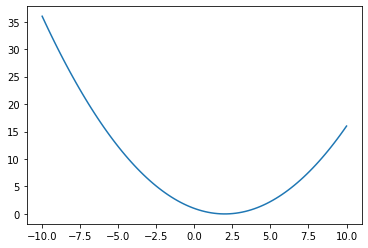

In [56]:
plt.plot(beta,loss)

#### 왼쪽/오른쪽중에 어디로 갈지 어떻게 판단하는 과정을 수식화?

`-` 아래와 같이 해석가능 

- 오른쪽으로 0.01 간다 = beta_old에 0.01을 더함. (if, 미분계수가 음수) 
- 왼쪽으로 0.01 간다. = beta_old에 0.01을 뺀다. (if, 미분계수가 양수) 

`-` 그렇다면 
$\beta_{new} = 
\begin{cases}
\beta_{old} + 0.01, & loss'(\beta_{old})< 0  \\ 
\beta_{old} - 0.01, & loss'(\beta_{old})> 0 
\end{cases}
$

#### 혹시 알고리즘을 좀 개선할수 있을까?

`-` 항상 0.01씩 움직여야 하는가? 

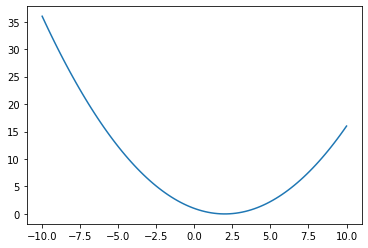

In [57]:
plt.plot(beta,loss)

`-` $\beta=-10$ 일 경우의 접선의 기울기? $\beta=-4$ 일때 접선의 기울기?

- $\beta=-10$ => 기울기는 -6 
- $\beta=-4$ => 기울기는 -3 

`-` 실제로 6,3씩 이동할순 없으니 적당한 $\alpha$ (예를들면 $\alpha=0.01$) 를 잡아서 곱한만큼 이동하자. 

`-` 수식화하면 

- $\beta_{new} = \beta_{old} - \alpha~ loss'(\beta_{old})$ 
- $\beta_{new} = \beta_{old} - \alpha~ \left[\frac{\partial}{\partial \beta }loss(\beta)\right]_{\beta=\beta_{old}}$ 

`-` $\alpha$의 의미
- $\alpha$가 크면 크게크게 움직이고 작으면 작게작게 움직인다. 
- $\alpha>0$ 이어야 한다. 

#### 구현코드 

`-` **iter 1**

$\beta=-10$이라고 하자. 

In [59]:
beta = tf.Variable(-10.0) 

In [60]:
with tf.GradientTape(persistent=True) as tape: 
    loss = (beta/2-1)**2 

In [61]:
tape.gradient(loss,beta)

<tf.Tensor: shape=(), dtype=float32, numpy=-6.0>

$\beta = -10$ 에서 0.01만큼 움직이고 싶음 

In [62]:
alpha= 0.01/6

In [63]:
alpha * tape.gradient(loss,beta)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.01>

In [65]:
beta.assign_sub(alpha * tape.gradient(loss,beta))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=-9.99>

In [66]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-9.99>

`-` **iter2**

In [67]:
with tf.GradientTape(persistent=True) as tape: 
    loss = (beta/2-1)**2 

In [69]:
beta.assign_sub(tape.gradient(loss,beta)*alpha)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=-9.980008>

`-` for 문을 이용하자.  

(강의용) 

In [74]:
beta = tf.Variable(-10.0) 

In [75]:
for k in range(10000): 
    with tf.GradientTape(persistent=True) as tape: 
        loss = (beta/2-1)**2 
    beta.assign_sub(tape.gradient(loss,beta)*alpha)

In [76]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.997125>

(시도1)

In [77]:
beta = tf.Variable(-10.0) 

In [78]:
for k in range(100): 
    with tf.GradientTape(persistent=True) as tape: 
        loss = (beta/2-1)**2 
    beta.assign_sub(tape.gradient(loss,beta)*alpha)

In [79]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-9.040152>

(시도2)

In [80]:
beta = tf.Variable(-10.0) 

In [81]:
for k in range(1000): 
    with tf.GradientTape(persistent=True) as tape: 
        loss = (beta/2-1)**2 
    beta.assign_sub(tape.gradient(loss,beta)*alpha)

In [82]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-3.2133687>

`-` 너무 느린 것 같다? $\to$ $\alpha$를 키워보자!

#### 학습률 

`-` $\alpha$에 따라서 수렴과정이 어떻게 달라지는 시각화해보자. 

##### [시각화 코드 예비학습] 

In [130]:
fig = plt.figure() # 도화지가 만들어지고 fig라는 이름을 붙인다. 

<Figure size 432x288 with 0 Axes>

In [131]:
ax = fig.add_subplot() # fig는 ax라는 물체를 만든다. 

In [132]:
id(fig.axes[0])

140064801700208

In [133]:
id(ax)

140064801700208

In [134]:
pnts, = ax.plot([1,2,3],[4,5,6],'or')
pnts

In [135]:
pnts.get_xdata()

array([1, 2, 3])

In [136]:
pnts.get_ydata()

array([4, 5, 6])

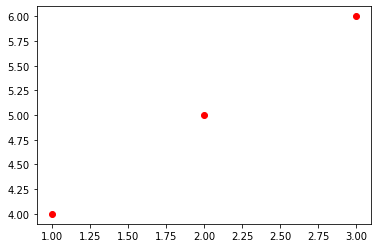

In [137]:
fig

In [138]:
pnts.set_ydata([5,5,5])

In [139]:
pnts.get_ydata()

[5, 5, 5]

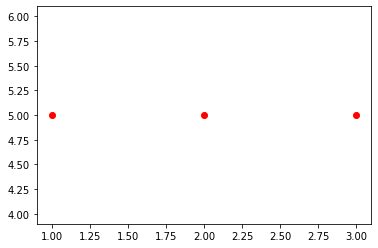

In [140]:
fig

`-` 응용 

In [143]:
## 20분 